### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults

### Carregar dados

In [2]:
# Carregar dados do CPU
machine = 'm_694.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_694,18.0,89.0,NaN,NaN,37.59,32.09,3.0
1970-01-01 00:01:00,m_694,20.0,89.0,NaN,NaN,37.60,32.09,4.0
1970-01-01 00:02:00,m_694,18.0,89.0,NaN,NaN,37.60,32.09,5.0
1970-01-01 00:03:00,m_694,18.0,88.0,NaN,NaN,37.60,32.09,4.0
1970-01-01 00:04:00,m_694,16.0,86.0,NaN,NaN,37.60,32.09,3.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_694,87.0,94.0,0.29,0.0,51.47,44.76,5.0
1970-01-08 23:56:00,m_694,85.0,94.0,0.55,0.0,51.47,44.76,5.0
1970-01-08 23:57:00,m_694,86.0,93.0,0.35,0.0,51.47,44.76,7.0


###  Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_perc = 1/(len(workload)//60)
test_len = int(len(workload)*test_perc)
str_test_perc = f'{test_len/len(workload):0.2f}'
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [4]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     84.510394
ar.L1      0.389090
sigma2     2.369388
dtype: float64

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [5]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 12, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    model_name = f'saved_models/arima_{str_test_perc.replace(".","")}_{"".join(map(str, order))}_{machine.replace(".csv", "")}.pkl'
    if not os.path.isfile(model_name):
        # cria e salva um modelo caso não exista
        model_train = ARIMA(train_set, order=order).fit()
        model_test = ARIMA(test_set, order=order, enforce_stationarity=False).fit(model_train.params)
        model_test.save(model_name)
        print(f"Modelo salvo em: '{model_name}' ")
    else:
        # carrega um modelo salvo
        model_test = ARIMAResults.load(model_name)
        
    # guarda os erros de cada modelo em uma lista
    predict_set = model_test.predict().shift(-1)[:-1]
    error = mse(test_set[:-1], predict_set)
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 2.7245768696922426 | (0, 0, 1) 1.5519797083552846 | (0, 0, 2) 1.3525735035971913 | (0, 0, 3) 3.982770822954931 | (0, 0, 4) 1.2574378165248048 | (0, 0, 5) 3.769009961448778 | (1, 0, 0) 1.0172099268975923 | (1, 0, 1) 1.4541126781123912 | (1, 0, 2) 1.306010641939817 | (1, 0, 3) 1.2569930152691238 | (1, 0, 4) 1.3251436591238535 | (1, 0, 5) 1.4416821516820006 | (2, 0, 0) 1.1403330311998388 | (2, 0, 1) 1.297748099529182 | (2, 0, 2) 1.7107925915809246 | (2, 0, 3) 1.537520507466416 | (2, 0, 4) 1.2782732373049501 | (2, 0, 5) 1.360235700687097 | (3, 0, 0) 1.1606625850633416 | (3, 0, 1) 1.259606556688197 | (3, 0, 2) 1.3090047296759912 | (3, 0, 3) 1.7437563147765813 | (3, 0, 4) 1.4238695407306323 | (3, 0, 5) 1.4894126139927095 | (4, 0, 0) 1.2674669241315377 | (4, 0, 1) 1.271703415521011 | (4, 0, 2) 1.311384831640195 | (4, 0, 3) 1.2858014190673202 | (4, 0, 4) 1.5407046819755412 | (4, 0, 5) 1.5053497860194405 | (5, 0, 0) 1.5645137226000663 | (5, 0, 1) 1.2810489461425363 | (5, 0, 2) 1.30333

### Execução do modelo com os melhores parâmetros

In [6]:
# modelo ARIMA
order=best_order
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     84.510394
ar.L1      0.389090
sigma2     2.369388
dtype: float64

### Comparar previsão x teste

Text(0, 0.5, '% cpu')

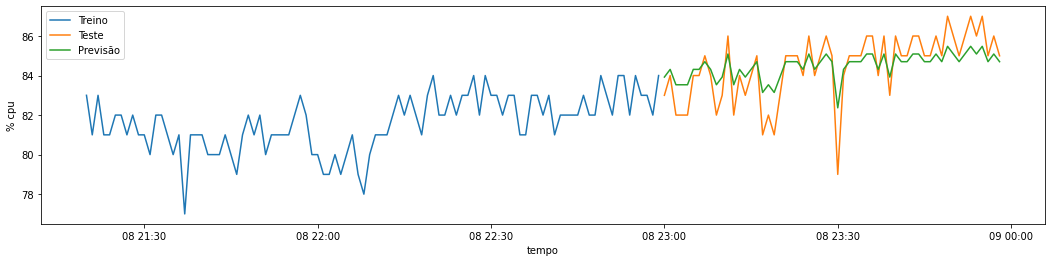

In [11]:
# compara a previsão com o conjunto de teste
predict_set = model_test.predict().shift(-1)[:-1]
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.legend(['Treino', 'Teste', 'Previsão'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Previsão de valores futuros

1970-01-09    85.479076
Freq: T, dtype: float64

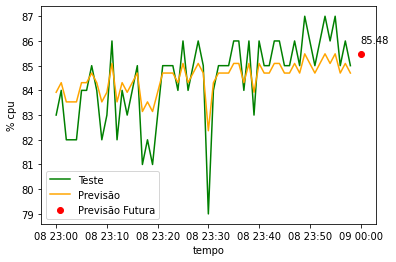

In [14]:
# Próximo passo
predict = model_test.forecast()
plt.figure(figsize=(6,4))
#plt.plot(train_set[-10:])
plt.plot(test_set[:-1], color='green')
plt.plot(predict_set, color='orange')
plt.scatter(predict.index, predict, color='red')
plt.text(predict.index, predict*1.005, f'{predict[0]:.2f}')
plt.legend(['Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')
predict

Text(0, 0.5, '% cpu')

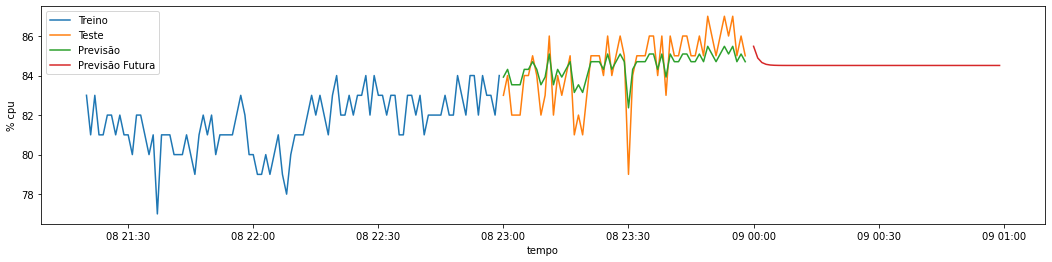

In [9]:
# Conjunto de passos futuros
predict = model_test.forecast(steps=60)
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set[:-1])
plt.plot(predict_set)
plt.plot(predict)
plt.legend(['Treino', 'Teste', 'Previsão', 'Previsão Futura'])
plt.xlabel('tempo')
plt.ylabel('% cpu')

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [10]:
mse(test_set[:-1], predict_set)

1.0172099268975923